# Optical Music Recognition - Vienna Dataset

In [2]:
# Import dependencies

import pandas as pd
import imageio 
import re
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from sklearn.utils import shuffle
from skimage import color
from matplotlib import pyplot as plt

In [27]:
# Label mapping

def map_pitch(pitch):

    m = {"a": 0,
         "h": 1,
         "c1": 2,
         "d1": 3,
         "e1": 4,
         "f1": 5,
         "g1": 6,
         "a1": 0,
         "h1": 1,
         "c2": 2,
         "d2": 3,
         "e2": 4,
         "f2": 5,
         "g2": 6,
         "a2": 0,
         "h2": 1,
         "c3": 2,
         "other": 7}
    
    return(m[pitch])

# Defining data classes

class ViennaNote:
    
    def __init__(self, fn, typ):
        attr = fn.split('-')
        
        if typ == 'test':
            ROOT = './data/originals-test/'
        elif typ == 'train':
            ROOT = './data/transformations-resized/'
        else:
            sys.exit()
            
        self.type = attr[0]
        self.time = attr[1]
        self.pitch = attr[2]
        imfile = imageio.imread(ROOT + fn)
        self.image = color.rgb2gray(imfile) / 255
        
    def resize_image(self, width, height):
        pass
    
# TODO: Combine test and input classes

class InputData:
    
    ROOT = './data/transformations-resized/' 
    
    def __init__(self, path = ROOT):
        self.files = [file for file in os.listdir(path) if os.path.isfile(path + file) and file[0:4] == 'note']
        self.objs = [ViennaNote(f, 'train') for f in self.files]
                
    def training_images(self, path = ROOT):
        images = [o.image for o in self.objs]
        return(np.array(images))
    
    def training_labels(self, path = ROOT):
        notes = [o.pitch for o in self.objs]
        labels = [map_pitch(pitch) for pitch in notes]
        return(np.array(labels))
    
    
class TestData:
    
    ROOT = './data/originals-test/' 
    
    def __init__(self, path = ROOT):
        self.files = [file for file in os.listdir(path) if os.path.isfile(path + file) and file[0:4] == 'note']
        self.objs = [ViennaNote(f, 'test') for f in self.files]
                
    def training_images(self, path = ROOT):
        images = [o.image for o in self.objs]
        return(np.array(images))
    
    def training_labels(self, path = ROOT):
        notes = [o.pitch for o in self.objs]
        labels = [map_pitch(pitch) for pitch in notes]
        return(np.array(labels))

In [17]:
# Instantiating objects
input_data = InputData()
train_images = input_data.training_images()
train_labels = input_data.training_labels()

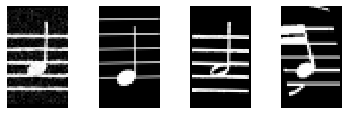

In [21]:
# Lets take a look at what a subset of our images look like
idxs = [120, 240, 360, 720]

for i in range(len(idxs)):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(train_images[i], cmap = 'Greys')
    plt.subplots_adjust(wspace = 0.5)

In [22]:
# I am going to use Convolutional Neural Networks which require images with 3 dims
# Each of my images only has 2 dims therefore I need to add a dim 
train_images = train_images.reshape(len(train_images), 50, 30, 1)

In [23]:
# Now I define the sequential keras NN and compile it
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(3, 5, input_shape=(50, 30, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(input_shape = (50, 30, 1)),
    tf.keras.layers.Dense(800, activation=tf.nn.relu),
    tf.keras.layers.Dense(160, activation=tf.nn.softmax),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Now we shuffle (keras shufles automatically but it takes the validation set before it does this)
train_images, train_labels = shuffle(train_images, train_labels)

In [25]:
# And finally, we fit the model to our data
model.fit(train_images, 
          train_labels,
          validation_split=0.3,
          epochs=5)

Epoch 1/5
859/859 [==============================] - 22s 25ms/step - loss: 1.2562 - accuracy: 0.5499 - val_loss: 0.2690 - val_accuracy: 0.9272
Epoch 2/5
859/859 [==============================] - 23s 27ms/step - loss: 0.1551 - accuracy: 0.9584 - val_loss: 0.0664 - val_accuracy: 0.9806
Epoch 3/5
859/859 [==============================] - 23s 26ms/step - loss: 0.0295 - accuracy: 0.9941 - val_loss: 0.0429 - val_accuracy: 0.9882
Epoch 4/5
859/859 [==============================] - 24s 29ms/step - loss: 0.0170 - accuracy: 0.9962 - val_loss: 0.0817 - val_accuracy: 0.9751
Epoch 5/5
859/859 [==============================] - 24s 28ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0247 - val_accuracy: 0.9930


In [59]:
# Lets test our model on a few test images (out of sample)

test_data = TestData().training_images().reshape(16, 50, 30, 1)
labs = TestData().training_labels()
CATEGORIES = ["a", "b", "c", "d", "e", "f", "g"]

print('Actual: ', [CATEGORIES[i] for i in labs.tolist()])
print('Predictions: ', [CATEGORIES[i] for i in np.argmax(model.predict(test_data), axis = 1)])

Actual:  ['c', 'e', 'a', 'e', 'a', 'a', 'c', 'e', 'd', 'c', 'd', 'a', 'c', 'a', 'a', 'a']
Predictions:  ['c', 'e', 'a', 'e', 'a', 'a', 'c', 'e', 'd', 'c', 'd', 'a', 'c', 'a', 'a', 'a']


### Spot on!